### Multiple Sequence Alignment

The aim of this notebook is to conduct a multiple sequence alignment (henceforth **MSA**).

**MSA** methods refer to a series of algorithmic solution for the alignment of evolutionarily related sequences, while taking into account evolutionary events such as mutations, insertions, deletions and rearrangements under certain conditions. These methods can be applied to DNA, RNA or protein sequences. (https://academic.oup.com/bib/article/17/6/1009/2606431)

For this we will use the *homology* file obtained from MobiDB source, containing basic information about sequences: 
accession codes from UniProt, types of annotations, classes of proteins, source, start and end positions, content fraction, content count and ids of the regions. 

We will also use the files of FASTA format (*curated_uniprot.fasta_*) with the additional information of hsp regions and the amino acid sequences.

In [2]:
import argparse
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from os import path
import sys
import json
import os
import subprocess
from Bio.Blast import NCBIXML

In [3]:
# Check the current directory for assigning the variable for the functions below

print('Get current working directory : ', os.getcwd())

Get current working directory :  /Users/alina/HMMER


In [4]:
directory = "/Users/alina/HMMER"

In [6]:
# Parse the fasta file to create a pandas dataframe

input_files = ['{}/curated_uniprot.fasta_75'.format(directory)]
dfs = []
max_query_length = 0

for input_file in input_files:
    with open(input_file) as f:
        blast_records = NCBIXML.parse(f)
        data = []

        # Iterate PSIBLAST rounds
        for blast_record in blast_records:
            query_id = blast_record.query

            # Get the length of the query sequence
            query_length = int(blast_record.query_letters)
            if query_length > max_query_length:
                max_query_length = query_length

            # Iterate alignments (here just one)
            for i, alignment in enumerate(blast_record.alignments):
                subject_id = alignment.title

                # Iterate pairwise alignments
                for hsp in alignment.hsps:
                    data.append((query_id,
                                    subject_id,
                                    query_length,
                                    hsp.query,
                                    hsp.match,
                                    hsp.sbjct,
                                    hsp.query_start,
                                    hsp.query_end,
                                    hsp.sbjct_start,
                                    hsp.sbjct_end,
                                    hsp.identities,
                                    hsp.positives,
                                    hsp.gaps,
                                    hsp.expect,
                                    hsp.score))

                    # Skip duplicated subjects
                    break

        dfs.append(pd.DataFrame(data, columns=["query_id", "subject_id", "query_len",
                                        "query_seq", "match_seq", "subject_seq",
                                    "query_start", "query_end", "subject_start", "subject_end", 
                                    "identity", "positive", "gaps", "eval", "bit_score"]))

In [146]:
# Print the resulting dataframe with shortened query and subject ID

df = dfs[0]
df['q_id'] = df['query_id'].str.split(" ").str[0]
df['s_id'] = df['subject_id'].str.split(" ").str[0]
df = df.set_index('s_id').reset_index()
df = df.set_index('q_id').reset_index()
df

,q_id,s_id,query_id,subject_id,query_len,query_seq,match_seq,subject_seq,query_start,query_end,subject_start,subject_end,identity,positive,gaps,eval,bit_score
0,sp|Q16620|NTRK2_HUMAN,tr|A0A2R9BM51|A0A2R9BM51_PANPA,sp|Q16620|NTRK2_HUMAN BDNF/NT-3 growth factors...,tr|A0A2R9BM51|A0A2R9BM51_PANPA Tyrosine-protei...,822,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,1,822,1,822,822,822,0,0.000000e+00,4458.0
1,sp|Q16620|NTRK2_HUMAN,tr|A0A2J8MRP9|A0A2J8MRP9_PANTR,sp|Q16620|NTRK2_HUMAN BDNF/NT-3 growth factors...,tr|A0A2J8MRP9|A0A2J8MRP9_PANTR Tyrosine-protei...,822,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,1,822,1,822,822,822,0,0.000000e+00,4458.0
2,sp|Q16620|NTRK2_HUMAN,tr|A0A6D2VUB3|A0A6D2VUB3_PANTR,sp|Q16620|NTRK2_HUMAN BDNF/NT-3 growth factors...,tr|A0A6D2VUB3|A0A6D2VUB3_PANTR Tyrosine-protei...,822,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,1,822,1,822,822,822,0,0.000000e+00,4458.0
3,sp|Q16620|NTRK2_HUMAN,tr|Q548C2|Q548C2_HUMAN,sp|Q16620|NTRK2_HUMAN BDNF/NT-3 growth factors...,tr|Q548C2|Q548C2_HUMAN Tyrosine-protein kinase...,822,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,1,822,1,822,822,822,0,0.000000e+00,4458.0
4,sp|Q16620|NTRK2_HUMAN,sp|Q16620|NTRK2_HUMAN,sp|Q16620|NTRK2_HUMAN BDNF/NT-3 growth factors...,sp|Q16620|NTRK2_HUMAN BDNF/NT-3 growth factors...,822,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,1,822,1,822,822,822,0,0.000000e+00,4458.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8651,tr|Q9X0T1|Q9X0T1_THEMA,tr|A0A7Y5V3I1|A0A7Y5V3I1_9CHLR,tr|Q9X0T1|Q9X0T1_THEMA Maltose ABC transporter...,tr|A0A7Y5V3I1|A0A7Y5V3I1_9CHLR Extracellular s...,391,LVIALLVVSLVVLAQPKLTIWCSEKQVDILQKLGEEFKAKYGVEVE...,LV LL V + +P L IW + L +L F ++GV VE...,LVFGLLAVPALAQDRPDLLIWADRTRTPPLTELATTFAEEFGVTVE...,5,390,14,397,141,220,4,7.015510e-82,695.0
8652,tr|Q9X0T1|Q9X0T1_THEMA,tr|A0A2M8NZZ8|A0A2M8NZZ8_9CHLR,tr|Q9X0T1|Q9X0T1_THEMA Maltose ABC transporter...,tr|A0A2M8NZZ8|A0A2M8NZZ8_9CHLR Maltose ABC tra...,391,FLVIALLVVSLVVL----AQPKLTIWCSEKQVDILQKLGEEFKAKY...,L++A++ +L VL L IW + + IL+ LG +FK ++...,LLIVAVMFGALGVLNVRAQDATLLIWADDTRAPILEALGAKFKEEF...,4,387,9,405,152,241,29,7.935620e-82,679.0
8653,tr|Q9X0T1|Q9X0T1_THEMA,tr|A0A7Y2F1B7|A0A7Y2F1B7_9ACTN,tr|Q9X0T1|Q9X0T1_THEMA Maltose ABC transporter...,tr|A0A7Y2F1B7|A0A7Y2F1B7_9ACTN Maltose ABC tra...,391,KLTIWCSEKQVDILQKLGEEFKAKYGVEVEVQYVNFQDIKSKFLTA...,L +W + + + + F+ GV +EVQ V+F DI+ + A...,SLLVWTDANRAPVFESIAPAFEEATGVNIEVQIVDFGDIREQVQVA...,21,387,71,436,133,208,3,1.031540e-81,681.0
8654,tr|Q9X0T1|Q9X0T1_THEMA,tr|A0A101IFE6|A0A101IFE6_9CHLR,tr|Q9X0T1|Q9X0T1_THEMA Maltose ABC transporter...,tr|A0A101IFE6|A0A101IFE6_9CHLR Putative ABC tr...,391,KLTIWCSEKQVDILQKLGEEFKAKYGVEVEVQYVNFQDIKSKFLTA...,+ IW E++ +L +L +F A+YGVE+ V+ N I+ +F A...,SIRIWADEQRAPVLSELATDFLAEYGVELVVE--NISGIRDQFSVA...,21,391,63,424,151,214,11,1.137790e-81,687.0


In [225]:
df['subject_seq'].value_counts()

MSAQPVDIQIFGRSLRVNCPPDQRDALNQAADDLNQRLQDLKERTRVTNTEQLVFIAALNISYELAQEKAKTRDYAASMEQRIRMLQQTIEQALLEQGRITEKTNQNFE                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        173
MRGDRGRGRGGRFGSRGGPGGGFRPFVPHIPFDFYLCEMAFPRVKPAPDETSFSEALLKRNQDLAPNSAEQASILSLVTKINNVIDNLIVAPGTFEVQIEEVRQVGSYKKGTMTTGHNVADLVVILKILPTLEAVAALGNKVVESLRAQDPSEVLTMLTNETGFEISSSDATVKILITTVPPNLRKLDPELHLDIKVLQSALAAIRHARWFEENASQSTVKVLIRLLKDLRIRFPGFEPLTPWILDLLGHYAVMNNPTRQPLALNVAYRRCLQILAAGLFLPGSVGITDPCESGNFRVHTVMT

Then we create a dataframe with the only 'query_seq', 'subject_seq' and 'count' columns, which shows the number of occurrences of each unique combination of these two columns.

In [147]:
# Counts the number of occurrences of each unique combination of these two columns

grouped = df.groupby(['query_seq', 'subject_seq']).size().reset_index(name='count')
grouped

,query_seq,subject_seq,count
0,AAAAAAAVAVPLAGGQEGSPGGGRRGSRGTTMVKKRKGRVVIDSDT...,AASGAGRVAVPLAGGQEGSPGGVRRGSRGTTMVKKRKGRVVIDSDT...,1
1,AAAAAGGAGGPGSGLAP-LPGLPPSAAAHGAALLSHWDPTLSSDWD...,AAEAIILQGAVGGGMVPHLSGLQPPGTSH-LATSSVWDPTASADWD...,1
2,AAAAAVAVPLAGGQEGSPGGGRRGSRGTTMVKKRKGRVVIDSDTED...,AAAAAVAVPLAGGQEGSPGGVRRGSRGTTMVKKRKGRVVIDSDTED...,1
3,AAAAGGAG-GPGSGLAPLPGLPPSAAAHGAALLSHWDPTLSSDWDG...,AAAAGGRGRGAGSGLAPLPGLPPSAAAHGAALLSHWDPTLSSDWDG...,1
4,AAAAGGAGGPGSGLAPLPGLPPSAAAHGAALLSHWDPTLSSDWDGE...,AAAAGGAGSPGSGLAPLPGLPPSAAAHGAALLSHWDPTLSSDWDGE...,1
...,...,...,...
6850,YRNCVYTYRILPNEDDKFTVQASEGVSMRFFTKLDQLIEFYKKENM...,YRNCVYTYRILPNED-KFSVQASEGVPMRFFTKLDQLIEFYKKENM...,1
6851,YRNCVYTYRILPNEDDKFTVQASEGVSMRFFTKLDQLIEFYKKENM...,YRNCVYTYRILPNED-KFSVQASEGVPMRFFTKLDQLIEFYKKENM...,1
6852,YRNCVYTYRILPNEDDKFTVQASEGVSMRFFTKLDQLIEFYKKENM...,YRNCVYTYRILPNDDDKFTVQASEGVPMRLFTKLDQLIEFYRKENM...,1
6853,YRNCVYTYRILPNEDDKFTVQASEGVSMRFFTKLDQLIEFYKKENM...,YRNCVYTYRILPNED-KFSVQASEGVPMRFFTKLDQLIEFYKKENM...,1


We need to focus on each query sequence and summarize the data for all subject sequences occurred, not the individual pair. For each query sequence we obtain the count of all subjects.

In [92]:
# Create 'grouped_counts' dataframe

grouped_counts = grouped.groupby('query_seq')['subject_seq'].nunique().reset_index(name='count')
grouped_counts

,query_seq,count
0,AAAAAAAVAVPLAGGQEGSPGGGRRGSRGTTMVKKRKGRVVIDSDT...,1
1,AAAAAGGAGGPGSGLAP-LPGLPPSAAAHGAALLSHWDPTLSSDWD...,1
2,AAAAAVAVPLAGGQEGSPGGGRRGSRGTTMVKKRKGRVVIDSDTED...,1
3,AAAAGGAG-GPGSGLAPLPGLPPSAAAHGAALLSHWDPTLSSDWDG...,1
4,AAAAGGAGGPGSGLAPLPGLPPSAAAHGAALLSHWDPTLSSDWDGE...,1
...,...,...
2847,YRNCVYTYRILPNEDDKFTVQASEGVSMRFFTKLDQLIEFYKKENM...,1
2848,YRNCVYTYRILPNEDDKFTVQASEGVSMRFFTKLDQLIEFYKKENM...,1
2849,YRNCVYTYRILPNEDDKFTVQASEGVSMRFFTKLDQLIEFYKKENM...,1
2850,YRNCVYTYRILPNEDDKFTVQASEGVSMRFFTKLDQLIEFYKKENM...,1


To analyze how many hits of subject sequences we obtained, we are using the unique() method. Using the number from this calculated column, we can filter out different query sequences.

In [148]:
# Check how many hits of subject sequences we obtained

grouped_counts['count'].unique()

array([  1,   6,   2,   3,   4,  10,   5,   8,  51,  53,  22,  12,   9,
        20,  18,   7,  11,  14,  57,  55,  17,  16,  61, 108,  68,  24,
        91,  26,  30, 105,  41,  13,  27, 133,  76,  25,  65,  38,  15,
        43,  75,  33,  48,  29,  70,  23,  32,  64,  19,  21])

Then we will merge two dataframes: initial df with all characteristics and the grouped with the calculated number of hits of all subject sequences for a particular query sequence.

In [227]:
# Merge two dataframes: initial df and the grouped

#merged = pd.merge(df, grouped, on='query_seq') # added the count column. Here is also added one extra subject_len
merged = pd.merge(df, grouped_counts, on='query_seq') # check which one is more correct, this or previous line. Should be this. The output plot is the same as before
merged # query_seq, q_id, count

,q_id,s_id,query_id,subject_id,query_len,query_seq,match_seq,subject_seq,query_start,query_end,subject_start,subject_end,identity,positive,gaps,eval,bit_score,count
0,sp|Q16620|NTRK2_HUMAN,tr|A0A2R9BM51|A0A2R9BM51_PANPA,sp|Q16620|NTRK2_HUMAN BDNF/NT-3 growth factors...,tr|A0A2R9BM51|A0A2R9BM51_PANPA Tyrosine-protei...,822,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,1,822,1,822,822,822,0,0.000000e+00,4458.0,68
1,sp|Q16620|NTRK2_HUMAN,tr|A0A2J8MRP9|A0A2J8MRP9_PANTR,sp|Q16620|NTRK2_HUMAN BDNF/NT-3 growth factors...,tr|A0A2J8MRP9|A0A2J8MRP9_PANTR Tyrosine-protei...,822,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,1,822,1,822,822,822,0,0.000000e+00,4458.0,68
2,sp|Q16620|NTRK2_HUMAN,tr|A0A6D2VUB3|A0A6D2VUB3_PANTR,sp|Q16620|NTRK2_HUMAN BDNF/NT-3 growth factors...,tr|A0A6D2VUB3|A0A6D2VUB3_PANTR Tyrosine-protei...,822,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,1,822,1,822,822,822,0,0.000000e+00,4458.0,68
3,sp|Q16620|NTRK2_HUMAN,tr|Q548C2|Q548C2_HUMAN,sp|Q16620|NTRK2_HUMAN BDNF/NT-3 growth factors...,tr|Q548C2|Q548C2_HUMAN Tyrosine-protein kinase...,822,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,1,822,1,822,822,822,0,0.000000e+00,4458.0,68
4,sp|Q16620|NTRK2_HUMAN,sp|Q16620|NTRK2_HUMAN,sp|Q16620|NTRK2_HUMAN BDNF/NT-3 growth factors...,sp|Q16620|NTRK2_HUMAN BDNF/NT-3 growth factors...,822,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,1,822,1,822,822,822,0,0.000000e+00,4458.0,68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8651,tr|Q9X0T1|Q9X0T1_THEMA,tr|A0A1N7Q2L3|A0A1N7Q2L3_9BACL,tr|Q9X0T1|Q9X0T1_THEMA Maltose ABC transporter...,tr|A0A1N7Q2L3|A0A1N7Q2L3_9BACL Maltodextrin-bi...,391,KLTIWCSE--KQVDILQKLGEEFKAKYGVEVEVQYVNFQDIKSKFL...,+L IW ++ + +K+ +E++ K G++V+V V+ + K ...,QLVIWENKDANHLKHTRKMAKEYEKKTGIQVKVVDVDILKQQEKLT...,21,391,100,472,149,226,8,4.440240e-82,686.0,1
8652,tr|Q9X0T1|Q9X0T1_THEMA,tr|A0A7Y5V3I1|A0A7Y5V3I1_9CHLR,tr|Q9X0T1|Q9X0T1_THEMA Maltose ABC transporter...,tr|A0A7Y5V3I1|A0A7Y5V3I1_9CHLR Extracellular s...,391,LVIALLVVSLVVLAQPKLTIWCSEKQVDILQKLGEEFKAKYGVEVE...,LV LL V + +P L IW + L +L F ++GV VE...,LVFGLLAVPALAQDRPDLLIWADRTRTPPLTELATTFAEEFGVTVE...,5,390,14,397,141,220,4,7.015510e-82,695.0,1
8653,tr|Q9X0T1|Q9X0T1_THEMA,tr|A0A2M8NZZ8|A0A2M8NZZ8_9CHLR,tr|Q9X0T1|Q9X0T1_THEMA Maltose ABC transporter...,tr|A0A2M8NZZ8|A0A2M8NZZ8_9CHLR Maltose ABC tra...,391,FLVIALLVVSLVVL----AQPKLTIWCSEKQVDILQKLGEEFKAKY...,L++A++ +L VL L IW + + IL+ LG +FK ++...,LLIVAVMFGALGVLNVRAQDATLLIWADDTRAPILEALGAKFKEEF...,4,387,9,405,152,241,29,7.935620e-82,679.0,1
8654,tr|Q9X0T1|Q9X0T1_THEMA,tr|A0A7Y2F1B7|A0A7Y2F1B7_9ACTN,tr|Q9X0T1|Q9X0T1_THEMA Maltose ABC transporter...,tr|A0A7Y2F1B7|A0A7Y2F1B7_9ACTN Maltose ABC tra...,391,KLTIWCSEKQVDILQKLGEEFKAKYGVEVEVQYVNFQDIKSKFLTA...,L +W + + + + F+ GV +EVQ V+F DI+ + A...,SLLVWTDANRAPVFESIAPAFEEATGVNIEVQIVDFGDIREQVQVA...,21,387,71,436,133,208,3,1.031540e-81,681.0,1


In [253]:
# ---

grouped_subj = df.groupby(['s_id', 'subject_seq']).size().reset_index(name='count')
grouped_counts_subj = grouped_subj.groupby('s_id')['subject_seq'].nunique().reset_index(name='count')
grouped_counts_subj['count'].unique()


array([1])

In [197]:
# Check the unique values of query ids

merged['q_id'].value_counts().unique()

array([200, 169,  73,  14])

In [198]:
# Check the unique values of subject ids

merged['s_id'].value_counts().unique() # each subject id repeats only once

array([1])

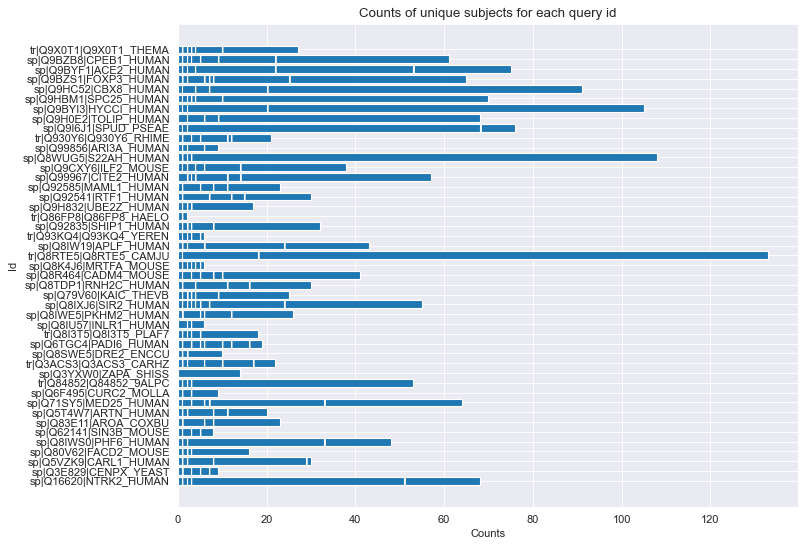

In [168]:
# Create a bar plot with the hits for each query ID

figure(figsize=(10, 8), dpi=80)
plt.barh(merged['q_id'], merged['count'])
plt.xlabel('Counts')
plt.ylabel('Id')
plt.title('Counts of unique subjects for each query id')
plt.show()

In [170]:
# Obtain the name of a particular query sequence to create a bar plot

gc = merged[merged['count'] == 57]
gc['query_seq'].unique()

array(['MADHMMAMNHGRFPDGTNGLHHHPAHRMGMGQFPSPHHHQQQQPQHAFNALMGEHIHYGAGNMNATSGIRHAMGPGTVNGGHPPSALAPAARFNNSQFMGPPVASQGGSLPASMQLQKLNNQYFNHHPYPHNHYMPDLHPAAGHQMNGTNQHFRDCNPKHSGGSSTPGGSGGSSTPGGSGSSSGGGAGSSNSGGGSGSGNMPASVAHVPAAMLPPNVIDTDFIDEEVLMSLVIEMGLDRIKELPELWLGQNEFDFMTDFVCKQQPSRVSC'],
      dtype=object)

In [211]:
# Choose 1 query_seq

#query_seq = 'MTERRLRVLVVEDESMIAMLIEDTLCELGHEVAATASRMQEALDIARKGQFDIAIIDVNLDGEPSYPVADILAERNVPFIFATGYGSKGLDTRYSNIPLLTKPFLDSELEAVLVQISKEV'
query_seq = 'DKFPTSVVSNCTDQCASYVANVFTTQPGGFIPSDFSFNNWFLLTNSSTLVSGKLVTKQPLLVNCLWPVPSFEEAASTFCFEGADFDQCNGAVLNNTVDVIRFNLNFTTNVQSGKGATVFSLNTTGGVTLEISCYNDTVSDSSFSSYGEIPFGVTNGPRYCYVLYNGTALKYLGTLPPSVKEIAISKWGHFYINGYNFFSTFPIDCISFNLTTGDSDVFWTIAYTSYTEALVQVENTAITNVTYCNSYVNNIKCSQLTANLNNGFYPVSSSEVGSVNKSVVLLPSFLTHTIVNITIGLGMKRSGYGQPIASTLSNITLPMQDNNTDVYCVRSDQFSVYVHSTCKSALWDNVFKRNCTDVLDATAVIKTGTCPFSFDKLNNYLTFNKFCLSLSPVGANCKFDVAARTRTNEQVVRSLYVIYEEGDSIVGVPSDNSGLHDLSVLHLDSCTDYNIYGRTGVGIIRQTNRTLLSGLYYTSLSGDLLGFKNVSDGVIYSVTPCDVSAQAAVIDGTIVGAITSINSELLGLTHWTITPNFYYYSIYNYTNDKTRGTPIDSNDVGCEPVITYSNIGVCKNGALVFINVTHSDGDVQPISTGNVTIPTNFTISVQVEYIQVYTTPVSIDCSRYVCNGNPRCNKLLTQYVSACQTIEQALAMGARLENMEVDSMLFVSENALKLASVEAFNSSETLDPIYTQWPNIGGFWLEGLKYILPSDNSKRKYRSAIEDLLFSKVVTSGLGTVDEDYKRCTGGYDIADLVCAQYYNGIMVLPGVANADKMTMYTASLAGGITLGAFGGGAVSIPFAVAVQARLNYVALQTDVLNKNQQILASAFNQAIGNITQSFGKVNDAIHQTSRGLTTVAKALAKVQDVVNTQGQALRHLTVQLQNNFQAISSSISDIYNRLDELSADAQVDRLITGRLTALNAFVSQTLTRQAEVRASRQLAKDKVNECVRSQSQRFGFCGNGTHLFSLANAAPNGMIFFHTVLLPTAYETVTAWSGICALDGDRTFGLVVKDVQLTLFRNLDDKFYLTPRTMYQPRVATSSDFVQIEGCDVLFVNTTVSDLPSIIPDYIDINQTVQDILENFRPNWTVPELTLDVFNATYLNLTGEIDDLEFRSEKLHNTTVELAILIDNINNTLVNLEWLNRIETYVKWPWYVWLLIGLVVIFCIPLLLFCCCSTGCCGCIGCLGSCCHSIFSRRQFENYEPIEKVHVH'


# Filter df by a particular query_seq
filtered_df = merged[merged['query_seq'] == query_seq]
filtered_df.head()

,q_id,s_id,query_id,subject_id,query_len,query_seq,match_seq,subject_seq,query_start,query_end,subject_start,subject_end,identity,positive,gaps,eval,bit_score,count,s_id_1
1974,tr|Q84852|Q84852_9ALPC,tr|Q6PQ05|Q6PQ05_9ALPC,tr|Q84852|Q84852_9ALPC Spike glycoprotein OS=P...,tr|Q6PQ05|Q6PQ05_9ALPC Spike glycoprotein OS=T...,1225,DKFPTSVVSNCTDQCASYVANVFTTQPGGFIPSDFSFNNWFLLTNS...,+K T+VVSNCTDQCASYVANVFTTQPGGFIPSDFSFNNWFLLTNS...,NKNGTTVVSNCTDQCASYVANVFTTQPGGFIPSDFSFNNWFLLTNS...,17,1225,241,1449,1177,1191,0,0.0,6259.0,51,tr|Q6PQ05|Q6PQ05_9ALPC NKNGT
1975,tr|Q84852|Q84852_9ALPC,tr|Q2LJ83|Q2LJ83_9ALPC,tr|Q84852|Q84852_9ALPC Spike glycoprotein OS=P...,tr|Q2LJ83|Q2LJ83_9ALPC Spike glycoprotein OS=T...,1225,DKFPTSVVSNCTDQCASYVANVFTTQPGGFIPSDFSFNNWFLLTNS...,+K T+VVSNCTDQCASYVANVFTTQPGGFIPSDFSFNNWFLLTNS...,NKNGTTVVSNCTDQCASYVANVFTTQPGGFIPSDFSFNNWFLLTNS...,17,1225,241,1449,1176,1190,0,0.0,6255.0,51,tr|Q2LJ83|Q2LJ83_9ALPC NKNGT
1976,tr|Q84852|Q84852_9ALPC,tr|Q0PL30|Q0PL30_CVPMI,tr|Q84852|Q84852_9ALPC Spike glycoprotein OS=P...,tr|Q0PL30|Q0PL30_CVPMI Spike glycoprotein OS=T...,1225,DKFPTSVVSNCTDQCASYVANVFTTQPGGFIPSDFSFNNWFLLTNS...,+K T+VVSNCTDQCASYVANVFTTQPGGFIPSDFSFNNWFLLTNS...,NKNGTTVVSNCTDQCASYVANVFTTQPGGFIPSDFSFNNWFLLTNS...,17,1225,241,1449,1176,1190,0,0.0,6249.0,51,tr|Q0PL30|Q0PL30_CVPMI NKNGT
1977,tr|Q84852|Q84852_9ALPC,tr|Q0PL21|Q0PL21_CVPMI,tr|Q84852|Q84852_9ALPC Spike glycoprotein OS=P...,tr|Q0PL21|Q0PL21_CVPMI Spike glycoprotein OS=T...,1225,DKFPTSVVSNCTDQCASYVANVFTTQPGGFIPSDFSFNNWFLLTNS...,+K T+VVSNCTDQCASYVANVFTTQPGGFIPSDFSFNNWFLLTNS...,NKNGTTVVSNCTDQCASYVANVFTTQPGGFIPSDFSFNNWFLLTNS...,17,1225,241,1448,1176,1189,1,0.0,6242.0,51,tr|Q0PL21|Q0PL21_CVPMI NKNGT
1978,tr|Q84852|Q84852_9ALPC,sp|P33470|SPIKE_CVPMI,tr|Q84852|Q84852_9ALPC Spike glycoprotein OS=P...,sp|P33470|SPIKE_CVPMI Spike glycoprotein OS=Po...,1225,DKFPTSVVSNCTDQCASYVANVFTTQPGGFIPSDFSFNNWFLLTNS...,+K T+VVSNCTDQCASYVANVFTTQPGGFIPSDFSFNNWFLLTNS...,NKNGTTVVSNCTDQCASYVANVFTTQPGGFIPSDFSFNNWFLLTNS...,17,1225,241,1449,1175,1189,0,0.0,6240.0,51,sp|P33470|SPIKE_CVPMI NKNGT


In [219]:
# Check how many hits of subject sequences we have for the chosen query sequence

#counts = filtered_df['subject_seq'].value_counts()
counts = filtered_df['s_id'].value_counts().reset_index(name='count') # if we filter subject sequences
#counts = filtered_df['s_id'].value_counts().reset_index(name='count') # if we filter subject ids. However, only 1 is the count value in this case
counts

,index,count
0,tr|Q6PQ05|Q6PQ05_9ALPC,1
1,tr|A0A384V9T3|A0A384V9T3_9ALPC,1
2,tr|A0A140EDK0|A0A140EDK0_9ALPC,1
3,tr|A0A1L6BQA9|A0A1L6BQA9_9ALPC,1
4,tr|Q84853|Q84853_9ALPC,1
5,tr|A0A3T0JMA0|A0A3T0JMA0_9ALPC,1
6,tr|A0A384V9D4|A0A384V9D4_9ALPC,1
7,tr|Q0PL04|Q0PL04_CVPPU,1
8,sp|Q01977|SPIKE_CVPRT,1
9,tr|A0A4Y6GTK3|A0A4Y6GTK3_9ALPC,1


TypeError: set_ticks() missing 1 required positional argument: 'ticks'

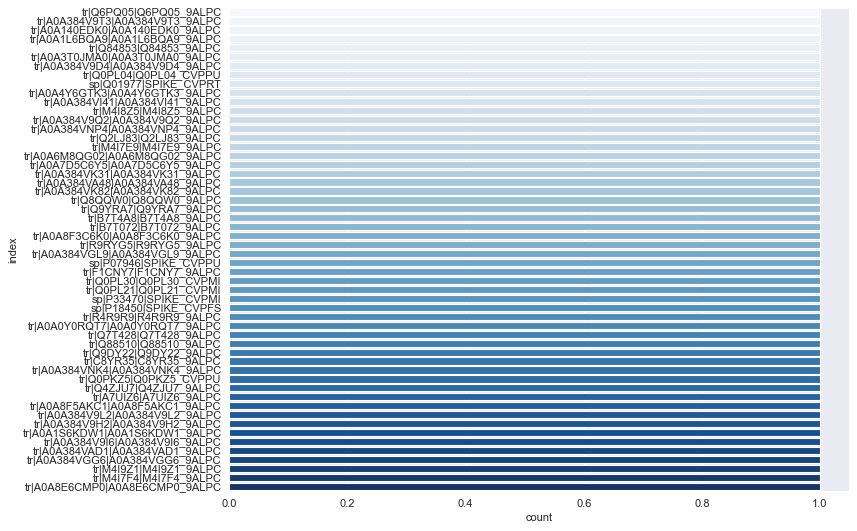

In [220]:
# Create a bar plot for the hits for the one selected query sequence

figure(figsize=(10, 8), dpi=80)
#ax = sns.barplot(x=counts.values, y=counts.index, palette='Blues') # when the column isn't named 'count'
ax = sns.barplot(data=counts, x='count', y='index', palette='Blues') # when the column is named 'count'
ax.set_yticks()
plt.xlabel('Count')
plt.ylabel('Subject Sequence')

In [208]:
# Create a hits_matrix 

hits_matrix = df.groupby('query_seq')['subject_seq'].nunique().reset_index()
hits_matrix

,query_seq,subject_seq
0,AAAAAAAVAVPLAGGQEGSPGGGRRGSRGTTMVKKRKGRVVIDSDT...,1
1,AAAAAGGAGGPGSGLAP-LPGLPPSAAAHGAALLSHWDPTLSSDWD...,1
2,AAAAAVAVPLAGGQEGSPGGGRRGSRGTTMVKKRKGRVVIDSDTED...,1
3,AAAAGGAG-GPGSGLAPLPGLPPSAAAHGAALLSHWDPTLSSDWDG...,1
4,AAAAGGAGGPGSGLAPLPGLPPSAAAHGAALLSHWDPTLSSDWDGE...,1
...,...,...
2847,YRNCVYTYRILPNEDDKFTVQASEGVSMRFFTKLDQLIEFYKKENM...,1
2848,YRNCVYTYRILPNEDDKFTVQASEGVSMRFFTKLDQLIEFYKKENM...,1
2849,YRNCVYTYRILPNEDDKFTVQASEGVSMRFFTKLDQLIEFYKKENM...,1
2850,YRNCVYTYRILPNEDDKFTVQASEGVSMRFFTKLDQLIEFYKKENM...,1


In [214]:
# pivot the hits_matrix to create a matrix of counts
#matrix_of_counts = hits_matrix.pivot_table(index='query_seq', values='subject_seq', aggfunc='count')
matrix_of_counts = hits_matrix.pivot_table(index='query_seq', columns='subject_seq', values='count')
#matrix_of_counts = hits_matrix.pivot_table(index='query_seq', columns='subject_seq', values='count')
matrix_of_counts

KeyError: 'count'

<AxesSubplot:xlabel='query_seq', ylabel='query_seq'>

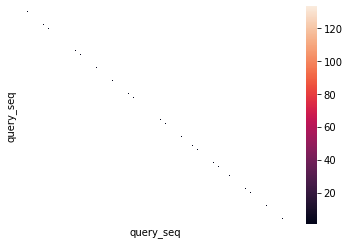

In [206]:
# Plot a heatmap

sns.heatmap(matrix_of_counts, xticklabels=False, yticklabels=False)

In [ ]:
# matrix N query_seq (rows): 2852, M subject_seq (columns): 6855

df['subject_seq'].nunique()

In [ ]:
# Generate the MSA

out_files = ["{}/output.fasta".format(directory)]

for df, out_file in zip(dfs, out_files):
    with open(out_file, "w") as fout:
        for index, row in df.iterrows():
            mapped_seq = ["-"] * max_query_length # Empty list of length = maximum query length
            c = 0
            if row["eval"] < 0.01:
                with open(out_file, "a") as fout: # append the output.fasta
                    for l_q, l_s in zip(row["query_seq"], row["subject_seq"]):
                        if l_q != " " and l_q != "-": # the element in query sequence
                            # avoid 'IndexError: list assignment index out of range'
                            if 1 <= row["query_start"] + c <= max_query_length:
                                mapped_seq[row["query_start"] + c - 1] = l_s if l_s != " " else "-"
                            c += 1
                    fout.write(">{}\n{}\n".format(row["subject_id"], "".join(mapped_seq)))